<a href="https://colab.research.google.com/github/Letsgetloud/Test/blob/main/Copie_de_Ensemble_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ensemble method

We train a meta-learner that will best combine the predictions from the different models and ideally perform better than any single sub-model.

In [1]:
import os 
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage import io
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold , cross_val_score , cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from numpy import dstack
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import joblib #to load and save sklearn models

GDRIVE_MOUNT_POINT = '/content/drive'
WORK_DIR = "/content/drive/MyDrive/work/Oliv"
MODEL_DIR = "/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/"

if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


Mounted at /content/drive


In [ ]:
#list all h5 models in a main directory
def listdirectory2(path): 
    fichier=[] 
    for root, dirs, files in os.walk(path): 
        if ("0002/train/0001" in root):
            for i in files:
                full_name= os.path.join(root, i)
                root, extension = os.path.splitext(full_name)
                if extension==".h5": fichier.append(full_name) 
    return fichier

listdirectory2(MODEL_DIR)


['/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb0/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb1/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb2/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb3/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb4/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb5/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb6/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb7/0002/train/0001/model/best_model.h5',
 '/content/drive/MyDrive/work/dad/output/classif

In [2]:
#Prepare the image test set for model evaluation

df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus_2k_clean.csv"
   ,  sep = ','
   ,  header = 0
)

filtre_genus=df_genus.taxon_name.value_counts().index[:10]
print(filtre_genus)
t= df_genus.shape
df_genus=df_genus[df_genus["taxon_name"].isin(filtre_genus)].reset_index()

#Prepare train and test sets
X= df_genus[df_genus["taxon_name"].isin(filtre_genus)][["img_path","taxon_name"]]

#split the dataset between 80% train, 20% validation and 10% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.125, random_state=1)

X_train, X_test = train_test_split(X, test_size=0.2, stratify = X["taxon_name"], random_state=88)
X_train, X_val= train_test_split(X_train, test_size=0.125,stratify = X_train["taxon_name"], random_state=43)


print("shape : ", t)
print("shape X genus: ", X.shape)
print("shape train: ", X_train.shape)
print("shape test:", X_test.shape)
print("shape valid: ", X_val.shape)

X_train.reset_index(drop=True, inplace=True)

list_genus= np.sort(np.array(X_val.taxon_name.value_counts().index))
y_val = []
for elem in list(X_val.taxon_name):
    y_val.append(np.argwhere(list_genus == elem)[0][0])

X_train_sclf, X_test_sclf, y_train_sclf, y_test_sclf = train_test_split(X_val, y_val, test_size=0.2, stratify = X_val["taxon_name"], random_state=1)

Index(['Amanita', 'Hygrocybe', 'Armillaria', 'Lactarius', 'Agaricus',
       'Gymnopus', 'Cortinarius', 'Russula', 'Marasmius', 'Entoloma'],
      dtype='object')
shape :  (27080, 39)
shape X genus:  (18560, 2)
shape train:  (12992, 2)
shape test: (3712, 2)
shape valid:  (1856, 2)


In [3]:
#STACKING MODEL CALIBRATION

#load models from file
def load_all_models():
    all_models = {}
    filenames = []
    for root, dirs, files in os.walk(MODEL_DIR): 
        if ("0002/train/0001" in root):
            for i in files:
                full_name= os.path.join(root, i)
                root, extension = os.path.splitext(full_name)
                if extension==".h5": filenames.append(full_name) 
    for file in filenames:
        if "xception" not in file:
            model = tf.keras.models.load_model(file)
            name = file.replace(MODEL_DIR, "")
            name = name.replace("/0002/train/0001/model/best_model.h5" , "")
            # add to list of members
            all_models[name]=model
            print('>Loading model %s' % file)
    return all_models


# load all models   
members = load_all_models()
print('Loaded %d models' % len(members))

stackX_train = None
stackX_test = None
results={}

for name, model in members.items():
    print("\n Analyzing ", name)
    IMG_SIZE= model.input.get_shape().as_list()[1:3]
    if "efficientnet" in name:
        preprocess_input = None
    elif "vgg16" in name:
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
    elif "vgg19" in name:
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
    elif "xception" in name:
        preprocess_input = tf.keras.applications.xception.preprocess_input
    else :
        raise NameError('No preprocess input specified') 
#else + exception 

    datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
    train_generator= datagen.flow_from_dataframe(dataframe=X_train_sclf, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=32)
    test_generator= datagen.flow_from_dataframe(dataframe=X_test_sclf, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=32)
    # evaluate standalone models on test dataset
    metrics = model.evaluate(train_generator)  #renvoi plusieurs scalars selon le nb de métrique choisies : loss, accuracy,..
    results[name] = metrics
    print('Model Accuracy: %.3f' % metrics[1])

    # make prediction
    print("Making predictions for " , name)
    y_train_pred = model.predict(train_generator, verbose=0)
    y_test_pred = model.predict(test_generator, verbose=0)
    # stack predictions into [rows, members, probabilities]
    if stackX_train is None:
        stackX_train = y_train_pred
    else:
        stackX_train = dstack((stackX_train, y_train_pred))
    if stackX_test is None:
        stackX_test = y_test_pred
    else:
        stackX_test = dstack((stackX_test, y_test_pred))

    del model

# flatten predictions to [rows, members x probabilities]
stackX_train = stackX_train.reshape((stackX_train.shape[0], stackX_train.shape[1]*stackX_train.shape[2]))
stackX_test = stackX_test.reshape((stackX_test.shape[0], stackX_test.shape[1]*stackX_test.shape[2]))


#try Logistic Regression
model_lr = LogisticRegression()
cv = StratifiedKFold(n_splits= 3, shuffle=True)
scores = cross_val_score(model_lr, stackX_train, y_train_sclf, cv = cv)
print("\n > Log Reg Accuracy mean " , '{:,.1%}'.format(np.mean(scores)), " std dev ",'{:,.1%}'.format(np.std(scores)))
#y_pred_lr = cross_val_predict(model_lr, stackX, val_generator.classes , cv=cv )
#print("\n", classification_report(val_generator.classes, y_pred_lr, target_names=list_genus))
#df_cm=pd.DataFrame(confusion_matrix(y_pred_lr,val_generator.classes))
#plt.figure(figsize = (10,5))
#sns.heatmap(df_cm, annot=True, fmt="d")

#print('\n\n>>>>>> Stacked Test Accuracy with LogReg model: %.3f' % acc)

#Try SVM
model_svm = SVC(probability=True)
scores = cross_val_score(model_svm, stackX_train, y_train_sclf, cv = cv)
print("\n > SVM Accuracy mean " , '{:,.1%}'.format(np.mean(scores)), " std dev ",'{:,.1%}'.format(np.std(scores)))
#y_pred_svm = cross_val_predict(model_svm, stackX, val_generator.classes , cv=cv )
#print("\n", classification_report(val_generator.classes, y_pred_svm, target_names=list_genus))
#df_cm=pd.DataFrame(confusion_matrix(y_pred_svm,val_generator.classes))
#plt.figure(figsize = (10,5))
#sns.heatmap(df_cm, annot=True, fmt="d")

#try decision tree
model_dtc = DecisionTreeClassifier()
scores = cross_val_score(model_dtc, stackX_train, y_train_sclf, cv = cv)
print("\n > Tree Accuracy mean " , '{:,.1%}'.format(np.mean(scores)), " std dev ",'{:,.1%}'.format(np.std(scores)))
#y_pred_dtc = cross_val_predict(model_dtc, stackX, val_generator.classes , cv=cv )
#print("\n", classification_report(val_generator.classes, y_pred_dtc, target_names=list_genus))

#le meta-learner permet d'atteindre 87% d'accuracy dépassant tous les autres 

>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb0/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb1/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb2/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb3/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb4/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb5/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb6/0002/train/0001/model/best_model.h5
>Loading model /content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientne

ResourceExhaustedError: ignored

In [ ]:
#META LEARNER CALIBRATION 

#fitting and predicting

knn_clf = KNeighborsClassifier()
dtc_clf = DecisionTreeClassifier()
lr_clf = LogisticRegression(max_iter=1000)
svm_clf = SVC()

knn_params = {"n_neighbors":[2,5,7,9]}
dtc_params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
svm_params = {"C" : np.logspace(-3,3,7)}
lr_params =  {"C" : np.logspace(-3,3,7)}

knn_clf = GridSearchCV(knn_clf, param_grid = knn_params , cv=5)
dtc_clf = GridSearchCV(dtc_clf, param_grid = dtc_params , cv=5)
svm_clf = GridSearchCV(svm_clf, param_grid = svm_params , cv=5)
lr_clf  = GridSearchCV(lr_clf, param_grid = lr_params , cv=5)

knn_clf.fit(stackX_train, y_train_sclf)
dtc_clf.fit(stackX_train, y_train_sclf)
svm_clf.fit(stackX_train, y_train_sclf)
lr_clf.fit(stackX_train, y_train_sclf)

y_pred_test_knn = knn_clf.best_estimator_.predict(stackX_test)
y_pred_test_dtc = dtc_clf.best_estimator_.predict(stackX_test)
y_pred_test_svm = svm_clf.best_estimator_.predict(stackX_test)
y_pred_test_lr = lr_clf.best_estimator_.predict(stackX_test)

print("\nKNN accuracy score on train : ", '{:,.1%}'.format(knn_clf.score(stackX_train, y_train_sclf)))
print("KNN accuracy score on test : ", '{:,.1%}'.format(knn_clf.score(stackX_test, y_test_sclf)))
print("\nTREE accuracy score on train : ", '{:,.1%}'.format(dtc_clf.score(stackX_train, y_train_sclf)))
print("TREE accuracy score on test : ", '{:,.1%}'.format(dtc_clf.score(stackX_test, y_test_sclf)))
print("\nSVM accuracy score on train : ", '{:,.1%}'.format(svm_clf.score(stackX_train, y_train_sclf)))
print("SVM accuracy score on test : ", '{:,.1%}'.format(svm_clf.score(stackX_test, y_test_sclf)))
print("\nLogReg accuracy score on train : ", '{:,.1%}'.format(lr_clf.score(stackX_train, y_train_sclf)))
print("LogReg accuracy score on test : ", '{:,.1%}'.format(lr_clf.score(stackX_test, y_test_sclf)))



KNN accuracy score on train :  84.4%
KNN accuracy score on test :  81.2%

TREE accuracy score on train :  89.3%
TREE accuracy score on test :  73.9%

SVM accuracy score on train :  90.9%
SVM accuracy score on test :  83.9%

LogReg accuracy score on train :  85.3%
LogReg accuracy score on test :  84.7%



               precision    recall  f1-score   support

    Agaricus       0.88      0.97      0.93        38
     Amanita       0.88      0.95      0.91        39
  Armillaria       0.79      0.79      0.79        38
 Cortinarius       0.94      0.81      0.87        37
    Entoloma       0.88      0.86      0.87        35
    Gymnopus       0.68      0.92      0.78        37
   Hygrocybe       0.97      0.82      0.89        38
   Lactarius       0.86      0.63      0.73        38
   Marasmius       0.89      0.86      0.87        36
     Russula       0.79      0.86      0.83        36

    accuracy                           0.85       372
   macro avg       0.86      0.85      0.85       372
weighted avg       0.86      0.85      0.85       372



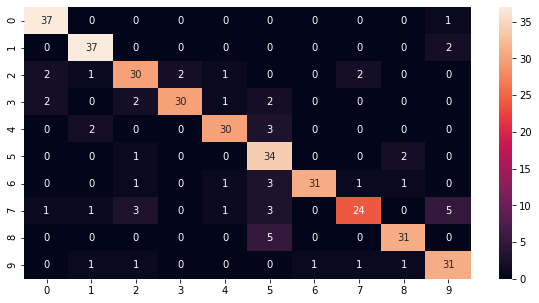

In [ ]:
print("\n", classification_report(y_test_sclf, y_pred_test_lr, target_names=list_genus))
df_cm=pd.DataFrame(metrics.confusion_matrix(y_test_sclf, y_pred_test_lr))
plt.figure(figsize = (10,5))
sns.heatmap(df_cm, annot=True, fmt="d")

In [ ]:
#Show accuracy on validation set for each of the individual CNN to be combined

pd.DataFrame(results, index=["Loss","Accuracy","Top2_Accuracy", "Top5_Accuracy"]).T.drop("Loss", axis=1)


,Accuracy,Top2_Accuracy,Top5_Accuracy
efficientnetb0,0.780323,0.896900,0.985175
efficientnetb1,0.739218,0.887466,0.975741
efficientnetb2,0.704178,0.848383,0.977763
efficientnetb3,0.717655,0.870620,0.979784
efficientnetb4,0.778302,0.901617,0.983154
efficientnetb5,0.831536,0.935984,0.987871
efficientnetb6,0.646226,0.801213,0.962264
efficientnetb7,0.676550,0.850404,0.973720
vgg16,0.465633,0.659030,0.896900
vgg19,0.451482,0.629380,0.886792


In [ ]:
#Finally save meta learner

filename = 'ensemble_model.sav'
joblib.dump(lr_clf, WORK_DIR +"/saved_model/"+ filename)